<a href="https://colab.research.google.com/github/JadeBenson/Wikipedia_DeepLearning/blob/main/tabular_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

raw_data_path = '/content/drive/MyDrive/UChicago/Spring2022/deep-learning/movies_and_posters.csv'
character_data_path = '/content/drive/MyDrive/UChicago/Spring2022/deep-learning/character.metadata.tsv'
destination_folder = '/content/drive/My Drive/UChicago/Spring2022/deep-learning/'

wiki = pd.read_csv(raw_data_path)
wiki = wiki[~wiki['Genre'].isna()]
chars = pd.read_csv(character_data_path,
                    sep='\t',
                    names=['wiki_movie_id', 'fb_movie_id', 'release_date', 'char_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'fb_map_id', 'fb_char_id', 'fb_actor_id'])


wiki['Genre'] = wiki['Genre'].apply(lambda x: x.split('|'))
genres = wiki['Genre'].sum()
genres = Counter(genres)
genres = [k for k, v in genres.items() if v > 900]
genres = dict(zip(genres, range(len(genres))))

one_hot_genres = []
for genre_list in wiki['Genre']: 
    one_hot_genre = np.zeros(len(genres))
    for genre in genre_list: 
        try:
            one_hot_genre[genres[genre]] = 1
        except KeyError: 
            continue
    one_hot_genres.append(one_hot_genre)

labels = np.array(one_hot_genres)
genres_i = [k for k, v in sorted(genres.items(), key=lambda x: x[1])]
wiki['label'] = list(labels)

mask = ((chars['actor_gender'].isna()) | (chars['fb_actor_id'].isna()) | (chars['actor_age'].isna()))
chars = chars[~mask]

actor_count = chars.groupby('wiki_movie_id')[['fb_actor_id']].count()
chars['male_ratio'] = chars['actor_gender'] == 'M'
male_ratio = chars.groupby('wiki_movie_id')[['male_ratio']].mean()
actor_age = chars.groupby('wiki_movie_id')[['actor_age']].mean()

actors = pd.concat([actor_count, male_ratio, actor_age], axis=1)
wiki = wiki.merge(actors, left_on='wiki_ID', right_index=True, how='inner')

wiki['tabular_input'] = list(wiki[['year','IMDB Score', 'fb_actor_id', 'actor_age', 'male_ratio']].values.round(2))
wiki = wiki[['plot', 'label', 'tabular_input']]

In [6]:
'''
import spacy
import re
import string

#tokenization
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

#count number of occurences of each word
counts = Counter()
for index, row in wiki.iterrows():
    counts.update(tokenize(row['plot']))

#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 10:
        del counts[word]
print("num_words after:",len(counts.keys()))
'''

KeyboardInterrupt: ignored

In [ ]:
#creating vocabulary
'''
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)
    '''

In [ ]:
'''
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

wiki['encoded'] = wiki['plot'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
wiki.head()
'''

,plot,label,tabular_input,encoded
0,"Set in the second half of the 22nd century, th...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2001.0, 4.9, 13.0, 43.46, 0.54]","[[2, 3, 4, 5, 6, 7, 4, 8, 9, 10, 11, 4, 12, 13..."
1,A series of murders of rich young women throug...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1987.0, 6.4, 2.0, 29.0, 0.5]","[[16, 206, 7, 207, 7, 208, 209, 37, 210, 211, ..."
2,"Adam, a San Francisco-based artist who works a...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1997.0, 6.1, 6.0, 35.17, 0.33]","[[449, 11, 16, 450, 451, 443, 452, 149, 453, 1..."
3,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1989.0, 7.7, 20.0, 45.9, 0.85]","[[8, 523, 1, 11, 524, 11, 524, 11, 524, 11, 52..."
4,The film opens with Mary Poppins perched in a...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1964.0, 7.8, 10.0, 37.6, 0.4]","[[4, 12, 426, 36, 550, 551, 11, 552, 3, 16, 55..."


## PyTorch Dataset

In [17]:
#posters = np.load('/content/drive/MyDrive/deep-learning/formatted_posters.npy')[wiki.index]

#X = list(wiki['encoded'])
y = list(wiki['label'])

tabular = list(wiki['tabular_input'])

y_train, y_valid = train_test_split(y, test_size=0.2, random_state=1)
#posters_train, posters_valid = train_test_split(posters, test_size=0.2, random_state=1)
tabular_train, tabular_valid = train_test_split(tabular, test_size=0.2, random_state=1)

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    def __init__(self, Y, tabular):
        #self.X = X
        #self.posters = posters
        self.y = Y
        self.tabular = tabular
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.y[idx], self.tabular[idx]

train_ds = MovieDataset(y_train, tabular_train)
valid_ds = MovieDataset(y_valid, tabular_valid)

batch_size = 32
#vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [20]:
import torch.nn.functional as F
import random

criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, epochs=10, lr=0.001):

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for y, t in train_dl:
            y = y.float().to(device)
            t = t.float().to(device)

            y_pred = model(t)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics(model, val_dl)
        print(f"Epoch {i}: train loss {round(sum_loss/total, 4)}, val loss {round(val_loss, 4)}")

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for y, t in valid_dl:
        y = y.float().to(device)
        t = t.float().to(device)

        with torch.no_grad():
            y_hat = model(t)
        loss = criterion(y_hat, y)
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

In [35]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TabularNet(torch.nn.Module) :
    def __init__(self) :
        super().__init__()

        self.fc1 = nn.Linear(5, 12)
        self.fc2 = nn.Linear(12, len(genres_i))
        #self.fc1 = nn.Linear(5, len(genres_i))
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, t):

        out = self.fc1(t)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

In [37]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model =  TabularNet().to(device)

In [38]:
train_model(model, epochs=50, lr=0.005)

Epoch 0: train loss 52.4921, val loss 51.7686
Epoch 1: train loss 51.9086, val loss 51.7686
Epoch 2: train loss 51.9086, val loss 51.7686
Epoch 3: train loss 51.9086, val loss 51.7686
Epoch 4: train loss 51.9086, val loss 51.7686
Epoch 5: train loss 51.9086, val loss 51.7686
Epoch 6: train loss 51.9086, val loss 51.7686
Epoch 7: train loss 51.9086, val loss 51.7686
Epoch 8: train loss 51.9086, val loss 51.7686
Epoch 9: train loss 51.9086, val loss 51.7686
Epoch 10: train loss 51.9086, val loss 51.7686
Epoch 11: train loss 51.9086, val loss 51.7686
Epoch 12: train loss 51.9086, val loss 51.7686
Epoch 13: train loss 51.9086, val loss 51.7686
Epoch 14: train loss 51.9086, val loss 51.7686
Epoch 15: train loss 51.9086, val loss 51.7686
Epoch 16: train loss 51.9086, val loss 51.7686
Epoch 17: train loss 51.9086, val loss 51.7686
Epoch 18: train loss 51.9086, val loss 51.7686
Epoch 19: train loss 51.9086, val loss 51.7686
Epoch 20: train loss 51.9086, val loss 51.7686
Epoch 21: train loss 51

In [26]:
start = True

for y, t in val_dl:
    y = y.float().to(device)
    t = t.float().to(device)
    with torch.no_grad():
        y_hat = model(t)
    logits = y_hat.detach().cpu().numpy()
    label_ids = y.to('cpu').numpy()
    if start: 
        probs = logits 
        test_labels = label_ids
        start = False
    else:
        probs = np.concatenate((probs, logits))
        test_labels = np.concatenate((test_labels, label_ids))
    

In [27]:
from sklearn import metrics
# precision, recall, accuracy, f1, roc_auc
genres_i = [k for k, v in sorted(genres.items(), key=lambda x: x[1])]

metric_dict = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': [],
    'roc_auc': []
}
for i, genre in enumerate(genres_i):
    metric_dict['f1_score'].append(metrics.f1_score(test_labels[:, i], probs[:, i] > .5))
    metric_dict['precision'].append(metrics.precision_score(test_labels[:, i], probs[:, i] > .5))
    metric_dict['recall'].append(metrics.recall_score(test_labels[:, i], probs[:, i] > .5))
    metric_dict['accuracy'].append(metrics.accuracy_score(test_labels[:, i], probs[:, i] > .5))
    metric_dict['roc_auc'].append(metrics.roc_auc_score(test_labels[:, i], probs[:, i] > .5))

metric_dict['genres'] = genres_i
metric_df = pd.DataFrame(metric_dict)
metric_df.sort_values('roc_auc', ascending=False, inplace=True)
metric_df

,f1_score,precision,recall,accuracy,roc_auc,genres
0,0.000000,0.000000,0.0,0.833725,0.5,Action
1,0.208641,0.116471,1.0,0.116471,0.5,Horror
2,0.000000,0.000000,0.0,0.850588,0.5,Thriller
3,0.000000,0.000000,0.0,0.638431,0.5,Comedy
4,0.000000,0.000000,0.0,0.808627,0.5,Romance
5,0.000000,0.000000,0.0,0.462353,0.5,Drama
6,0.142077,0.076471,1.0,0.076471,0.5,Family
7,0.231009,0.130588,1.0,0.130588,0.5,Adventure
8,0.000000,0.000000,0.0,0.832941,0.5,Crime
9,0.135965,0.072941,1.0,0.072941,0.5,Mystery


In [39]:
probs[0] # predictions

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)

## Logistic Regression to see if More Accurate than NN on Tabular Data

In [43]:
# year, IMDB Score, number of actors, avg actor_age , male:female actor ratio
#tabular[0]
y[0]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [47]:
y = list(wiki['label'])

tabular = list(wiki['tabular_input'])

y_train, y_valid = train_test_split(y, test_size=0.2, random_state=1)
#posters_train, posters_valid = train_test_split(posters, test_size=0.2, random_state=1)
tabular_train, tabular_valid = train_test_split(tabular, test_size=0.2, random_state=1)

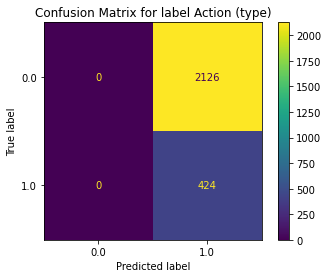

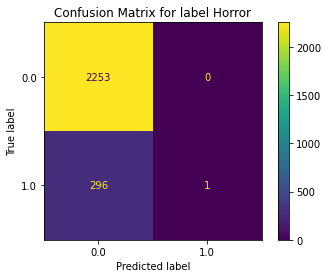

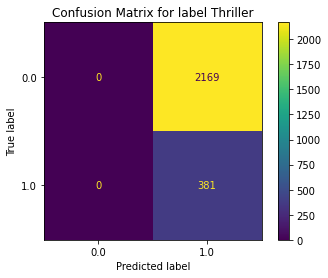

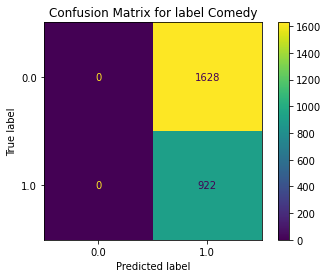

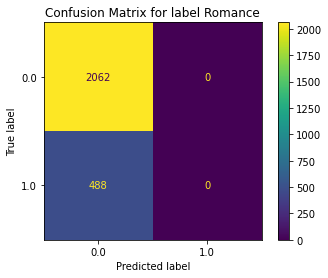

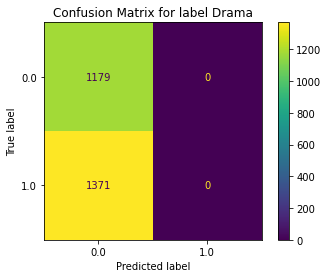

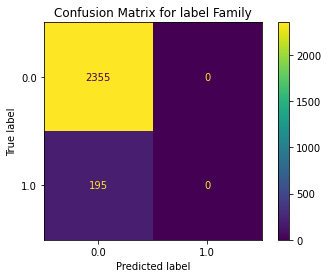

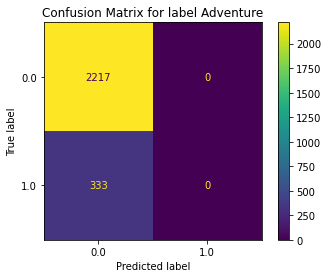

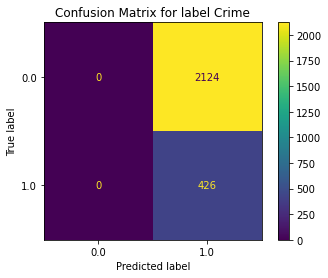

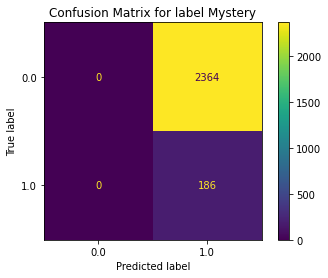

In [55]:
# Create the SVM
svm = LinearSVC(C=10, random_state=42)

# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(tabular_train, y_train)

# Get predictions for test data
y_test_pred = multilabel_classifier.predict(tabular_valid)

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_valid, y_test_pred)

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[0]} (type)')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[1]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[2], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[2]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[3], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[3]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[4], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[4]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[5], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[5]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[6], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[6]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[7], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[7]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[8], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[8]}')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[9], display_labels=np.unique(y_valid)).plot()
plt.title(f'Confusion Matrix for label {genres_i[9]}')
plt.show()